# 은행 고객 세분화

- 사용할 알고리즘 [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

In [0]:
# 데이터 다운로드
!curl -L https://bit.ly/2nnKpzH -o german_credit_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0   1935      0 --:--:-- --:--:-- --:--:--  1961
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 49689  100 49689    0     0  69886      0 --:--:-- --:--:-- --:--:-- 69886


In [0]:
data = pd.read_csv('german_credit_data.csv')
data[:3]

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education


### 첫번째 컬럼 삭제 

In [0]:
data = data.drop(['Unnamed: 0'], axis=1)

In [0]:
data[:3]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [0]:
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [0]:
print("결측치 갯수:\n{}".format(data.isnull().sum()))

결측치 갯수:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


- 결측치 발생은 해당사항이 없는 경우일 것이다.
- 카테고리 변수와 아날로그 변수는 Object와 int/float로 구분한다.
- 서로 다른 값의 종류(경우의 수)는 nunique로 찾는다

In [0]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [0]:
# 특정 카테고리 변수(Housing)에 대한 내용을 찾아 본다. unique() 사용
data['Age'].unique()

array([67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 32, 44, 31, 48, 26, 36,
       39, 42, 34, 63, 27, 30, 57, 33, 37, 58, 23, 29, 52, 50, 46, 51, 41,
       40, 66, 47, 56, 54, 20, 21, 38, 70, 65, 74, 68, 43, 55, 64, 75, 19,
       62, 59])

In [0]:
# 모든 카테고리 변수의 내용을 찾아본다
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [0]:
# 모든 아나로그 변수의 갯수만 확인한다.
for col in data.select_dtypes(include=[float, int]):
    print(col,":", data[col].nunique())

Age : 53
Job : 4
Credit amount : 921
Duration : 33


## 탐색적 분석 EDA(Exploratory Data Analysis)
- 세가지 아나로그 변수에 대해 산포도를 그리는 함수를 정의

In [0]:
def my(x,y,z=100):
  return x+ 10*y + z


a = my(1,2)
a

121

In [0]:
def scatters(data, h=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, data=data, ax=ax3)
    plt.tight_layout()

### Sex를 기준으로 나누어 (hue) 산포도를 그린다.

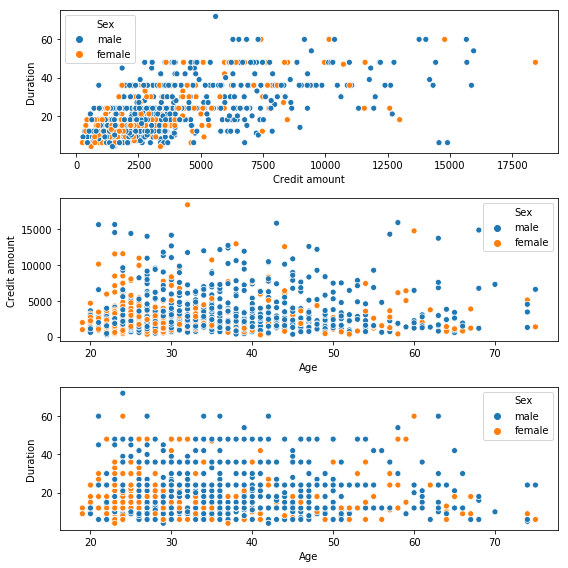

In [0]:
scatters(data, h="Sex")

- 전체적으로 여성이 남성보다 젊다는 것을 알 수 있다.
- 첫번째 그래프에서 크레딧의 기간과 양에서 남여의 차이가 별로 없음을 알 수 있다.
- 기간과 양이 약간의 상관관계가 있음을 알 수 있다.

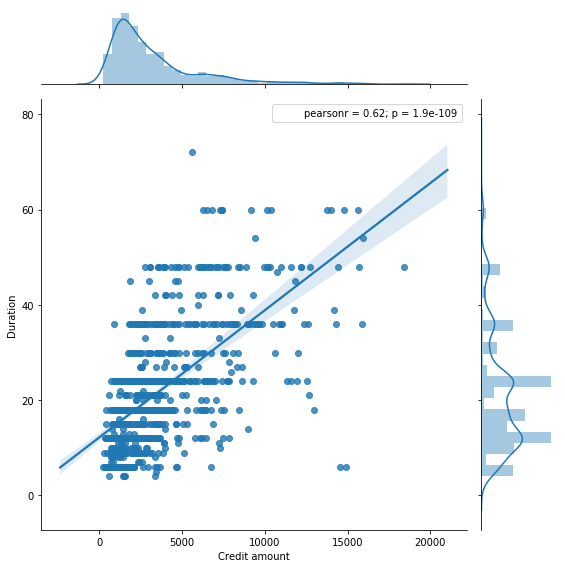

In [0]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=data, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

- Pearson 값은 0.62이고 작은 p-value를 갖는 것을 알 수 있다.
- 액수가 크면 기간이 긴 경향이 있다.
- 여러 카테고리 변수를 파라미터로 하여 선형 관계를 그려보겠다.

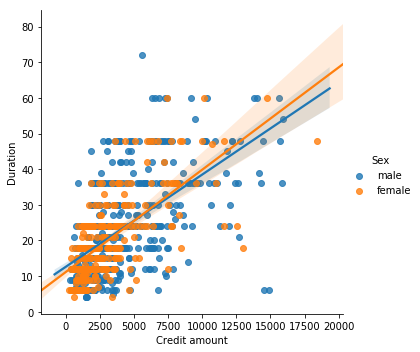

In [0]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data)
plt.show()

The plot above indicates that there is no significant difference between men and women.

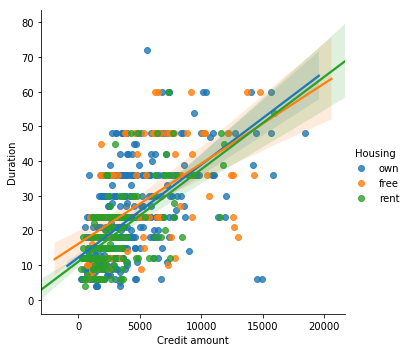

In [0]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data)
plt.show()

- housing category는 별 차이가 없다.
- 영역(Purpose)과 크레딧의 관계를 알아보겠다.

In [0]:
n_credits = data.groupby("Purpose")["Sex"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)
n_credits


,Purpose,Count
1,car,337
5,radio/TV,280
4,furniture/equipment,181
0,business,97
3,education,59
6,repairs,22
2,domestic appliances,12
7,vacation/others,12


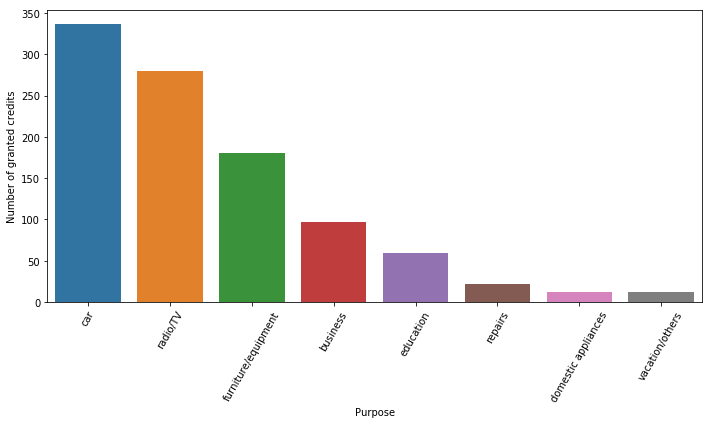

In [0]:
plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

- car와 radio/TV에 관한 크레딧이 많은 것을 알 수 있다.
## 박스플롯

In [0]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

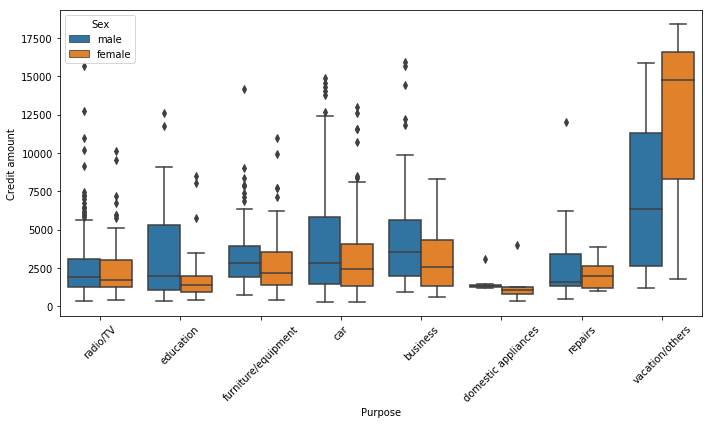

In [0]:
boxes("Purpose","Credit amount","Sex")

- 가장 큰 값은 vacations/others이고 작은 값은domestic appliances이다.
- 이상치 (1.5 IQR 밖)는 윗쪽에 나타난다. (IQR = 3/4 quartile - 1/4 quartile)
- 남녀의 차이는 별로 없다. vacation/others는 차이가 있어 보이지만 샘플 수가 적다.

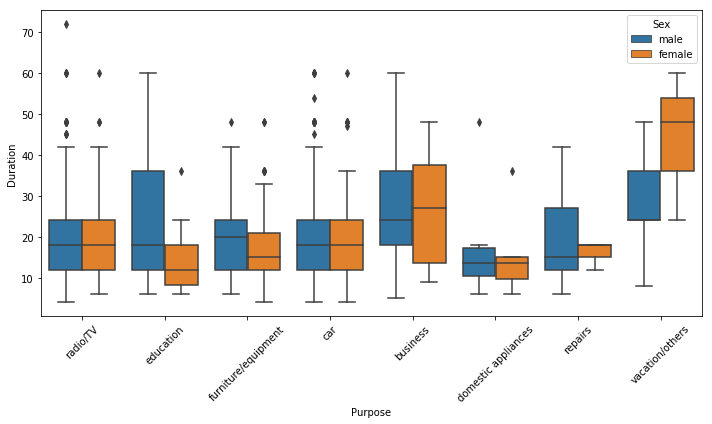

In [0]:
boxes("Purpose","Duration","Sex")

- 기간에 남녀의 차이는 없다.
- domestic appliances의 수치가 적다

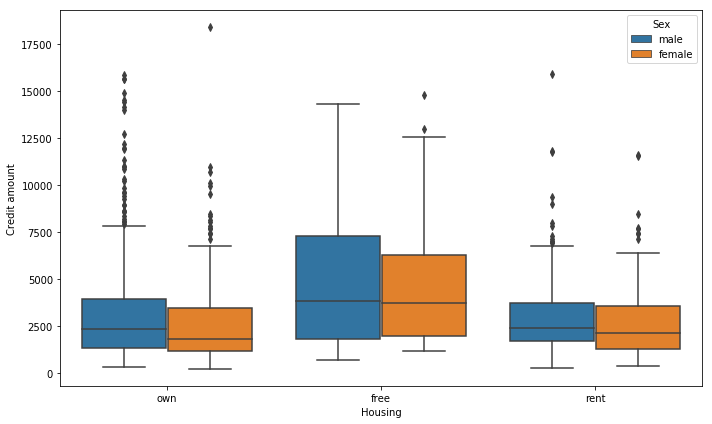

In [0]:
boxes("Housing","Credit amount","Sex",r=0)

- “free” housing의 경우 크레딧이 큰 편이다

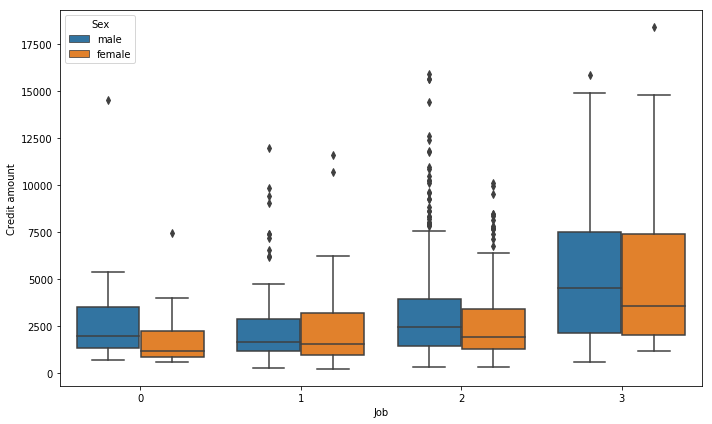

In [0]:
boxes("Job","Credit amount","Sex",r=0)

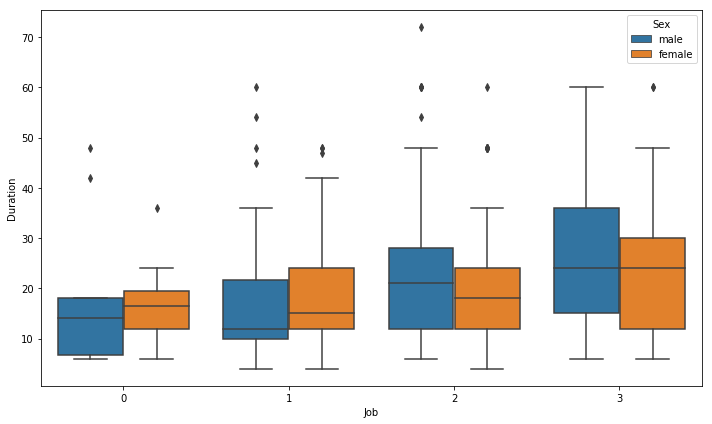

In [0]:
boxes("Job","Duration","Sex",r=0)

- 남여의 차이는 없지만 직업 3의 경우 값이 큰 것을 알 수 있다.

# 클러스터링

- KMeans 사용
- 어떤 특성(features)을 사용할지를 먼저 선택해야 한다.
- 예: (Age, Credit amount, Duration). 

In [0]:
# 사용할 특성을 선택한다
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

# 히스토그램 그리는 함수 정의

In [0]:
# 세가지 히스토그램을 그리는 함수
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

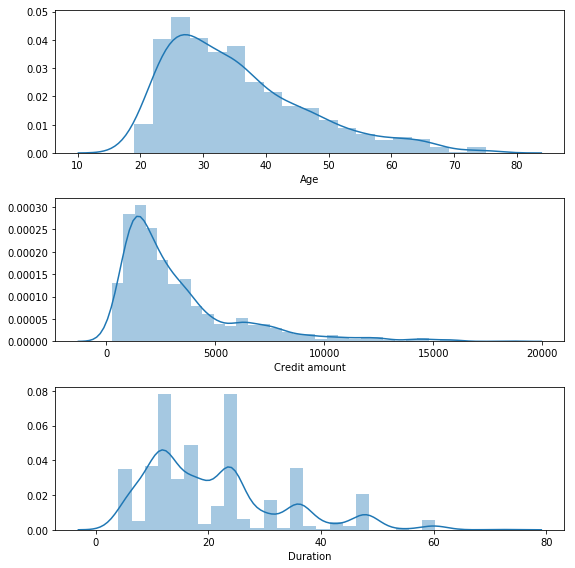

In [0]:
distributions(cluster_data)

- 분포를 보면 right-skewed 되어 있다
- To obtain better results we should remove the skewness by logarithmic transformation (??)

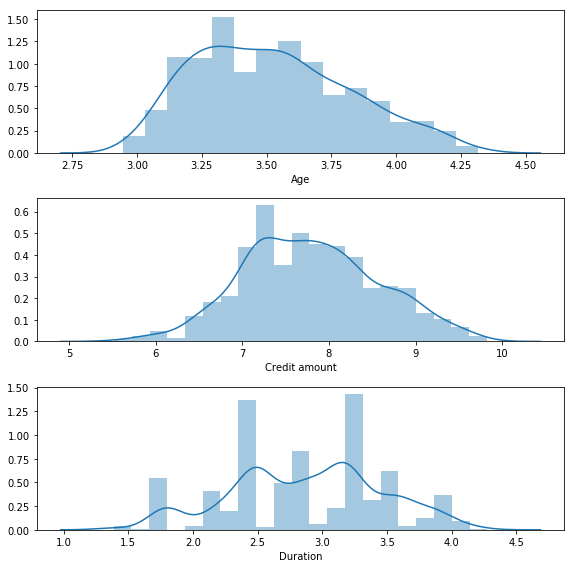

In [0]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

### 표준 정규화 (스케일링)

In [0]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

- 클러스터 내 샘플들의 오차 자승의 합 (SSE)을 구한다: inertia
- 여러가지 클러스트 갯수 경우의 수에 대해서

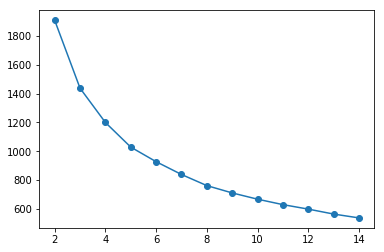

In [0]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

- knee 포인트, 또는 elbow 포인트 선택

In [0]:
from sklearn.metrics import silhouette_samples, silhouette_score

results =[]
for c in range(2,15):
  clusterer = KMeans(n_clusters=c)
  cluster_labels = clusterer.fit_predict(cluster_scaled)
  silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
  results.append([c,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","silhouette_score"])

In [0]:
result

,n_clusters,silhouette_score
0,2,0.315344
1,3,0.303189
2,4,0.267078
3,5,0.267453
4,6,0.262064
5,7,0.259355
6,8,0.258937
7,9,0.256993
8,10,0.253737
9,11,0.239353


- 클러스터 수를 3으로 선택한다.

In [0]:
kmeans_sel = KMeans(n_clusters=3).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

In [0]:
clustered_data[:10]

,Age,Credit amount,Duration,Cluster
0,67,1169,6,1
1,22,5951,48,0
2,49,2096,12,1
3,45,7882,42,0
4,53,4870,24,0
5,35,9055,36,0
6,53,2835,24,1
7,35,6948,36,0
8,61,3059,12,1
9,28,5234,30,0


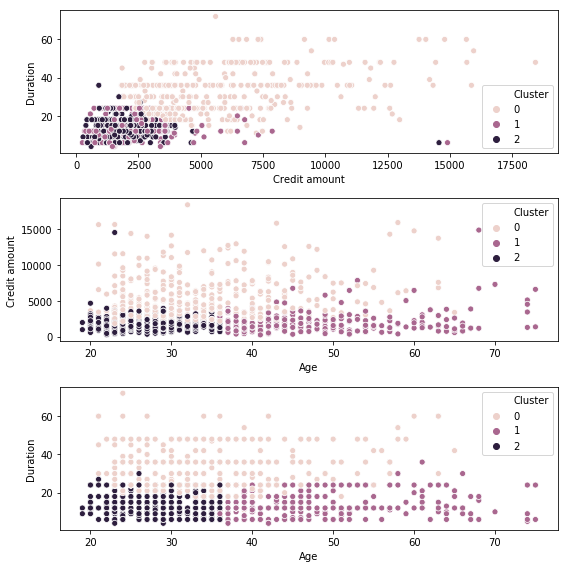

In [0]:
scatters(clustered_data, 'Cluster')

- 첫번째 산포도는 모호하지만 2, 3 번째는 명확하게 보인다.
- 수치를 확인한다.

In [0]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


### 의미 부여
Cluster 0 –  lower mean of credit amount, short duration, older customers  
Cluster 1 – high mean of credit amount, long duration, middle-aged customers  
Cluster 2 - lower mean of credit amount, short duration, young customers